# Portfolio Project 3 - Flowers Image Classifier

My other two portfolio projects have modelled tabular data, but I want to work on something different. For this Notebook I will create and optimise an image classifier that predicts which of the ten flower types an image most closely resembles.

For this project I will be using the dataset:

https://www.kaggle.com/datasets/aksha05/flower-image-dataset/download?datasetVersionNumber=1

## Business Justification

A flower farm are looking to automate their production facilites. They grow ten different types of flower but want to process and package them in a single facility using automation. To do this they need to be able to differentiate between the different types of flower they produce. After consultation they have decided that they need a machine learning model that can predict which type of flower a particular specimen is. Once they have a model they can move forward with embedding factorial systems to automate processing.

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd

import os
from pathlib import Path
import sys

import cv2
import matplotlib.pyplot as plt
import sklearn
# import skimage
from PIL import Image

from sklearn.linear_model import LogisticRegression

from distutils.dir_util import copy_tree

In [3]:
data_path = Path('flower_images')

### 1a. Inspect Data

Let's have a look at the data.

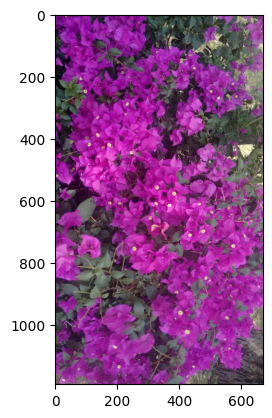

Sample shape : (1191, 670, 3)


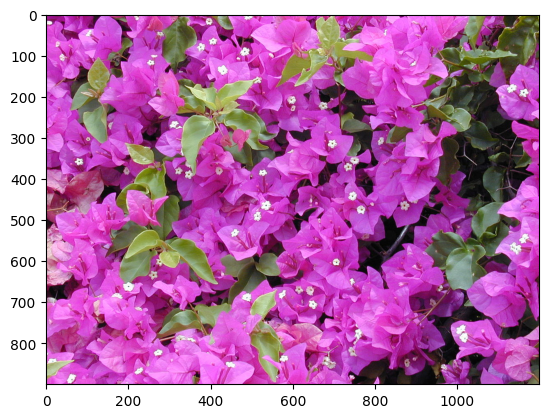

Sample shape : (900, 1200, 3)


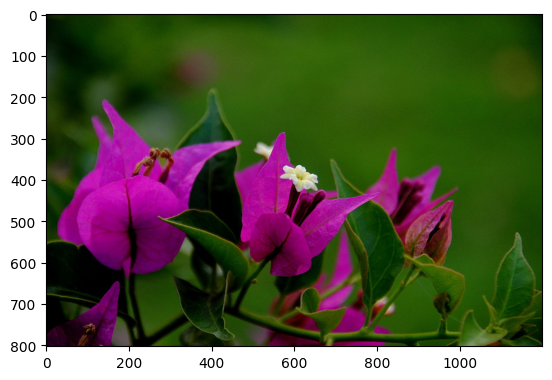

Sample shape : (803, 1200, 3)


In [4]:
imgs = list(data_path.iterdir())

for img in imgs[0:3]:
    sample = Image.open(img)
    sample_arr = np.asarray(sample)
    plt.imshow(sample_arr), plt.show()
    print("Sample shape :", sample_arr.shape)

## 2. Data Cleaning

As we can see, our images are of different sizes. This is a problem, because a tensor has a **regular** shape. Which means we can't make a tensor out of differently sized images!

We therefore have three options:

1. Scale all of the images to a single height/width
2. Scale all of the images to a maximum value of height or width, and fill the rest of the image with a single colour
3. Create a set of subimages from each image.

Personally I am not a fan of the first, it seems lazy. The second approach is better but not perfect because our model might infer some kind of relationship between the labels and the colour fill. The third is robust and a popular data augmentation technique, so we will use that.

The function we want to resize them (```Image.thumbnail```) operates in place, so we'll create a copy of our image folder and operate on the files in that. We aren't operating on our original images because it impedes Notebook functionality, and if we make any sort of mistake then we'll have to redownload the dataset.

Let's make a copy of our folder now.

In [5]:
data_path = Path('resized_flower_images')

In [6]:
# we'll put the copy_tree function in an if statement so it only executes if needed

if not data_path.exists():
    data_path.mkdir()
    src_dir = 'flower_images'
    dst_dir = 'resized_flower_images'
    copy_tree(src_dir, dst_dir)

In [7]:
len(list(data_path.iterdir()))

581

## 2a. Data Normalisation

We want to make sure every image in our dataset has appropriate dimensions - the ```min(height, width)``` for each picture has to be at least half the ```max(height, width)```. Then we can rescale each picture and create a set of subimgs.

In [8]:
def get_irregular_img_paths(path, min_differential = 1.5):
    # min_differential is the minimum permissible ratio difference between max(w, h) and min(w, h)
    # 1 = 100%, 2 = 50%, 3 = 33%, 4 = 25%, etc
    # if we set it as 2 then we return a list containing all imgs in path where max(w,h)/2 > min(w,h)
    # the problem with using the value 2 is that we'll have a lot of overlap in our sub images
    # this might introduce overfitting
    # we'll use 1.5 [75%] to prevent this
    img_paths = []
    for file in path.iterdir():
        with Image.open(file) as im:
            width, height = im.size
            # if the smallest axis [w/h] is less than half of the biggest axis
            if min(width, height) < int(max(width, height) / min_differential):
                img_paths.append(Path(file))
    return img_paths

In [9]:
# remove them
def remove_irregular_img_paths(image_folder_path):
    path_list = get_irregular_img_paths(image_folder_path)
    for path in path_list:
        os.remove(path)

In [59]:
remove_irregular_img_paths(data_path)

In [10]:
len(list(data_path.iterdir()))

581

Now we know that our images have regular shapes, we can resize them. Let's get their paths.

In [11]:
# get paths
img_paths = list(data_path.iterdir())
img_paths[0:5]

[WindowsPath('resized_flower_images/bougainvillea_00003.jpg'),
 WindowsPath('resized_flower_images/bougainvillea_00004.jpg'),
 WindowsPath('resized_flower_images/bougainvillea_00005.jpg'),
 WindowsPath('resized_flower_images/bougainvillea_00007.jpg'),
 WindowsPath('resized_flower_images/bougainvillea_00008.jpg')]

In [12]:
def resize_images_to_thumbnails(image_path_list, max_size):
    
    # max_size is the target max w or h of images
    size = (max_size, max_size)

    for file in paths:
        # split filename into components
        fn = str(file).split('\\')
        fn_elements = fn[-1].split('.')

        fn = fn_elements[0]
        ext = fn_elements[1]
        im = Image.open(file)
        im.thumbnail(size, Image.LANCZOS)
        im.save(f'{data_path}/{fn}.{ext}', 'JPEG')

In [13]:
img_size = 256

In [9]:
# we need this for later - it will save us hardcoding the values
resize_images_to_thumbnails(img_paths, img_size)

NameError: name 'resize_images_to_thumbnails' is not defined

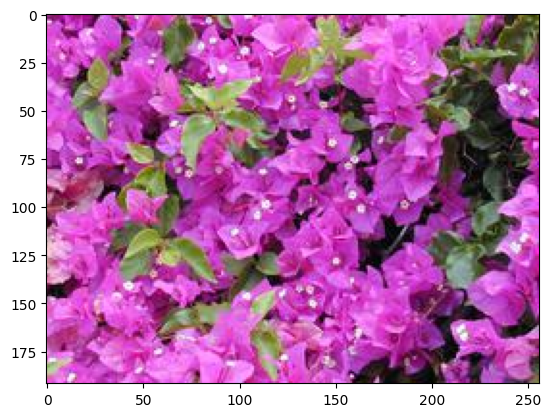

Sample shape : (192, 256, 3)


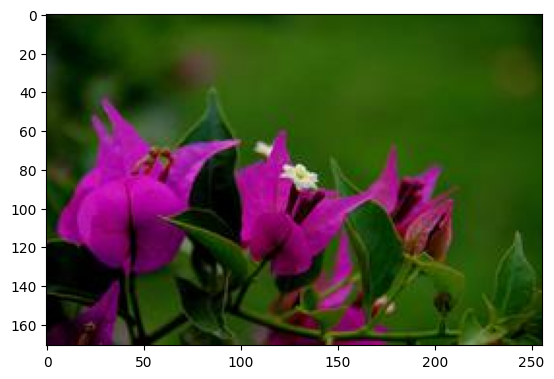

Sample shape : (171, 256, 3)


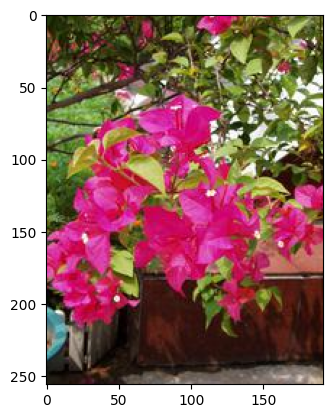

Sample shape : (256, 192, 3)


In [14]:
imgs = list(data_path.iterdir())

for img in imgs[0:3]:
    sample = Image.open(img)
    sample_arr = np.asarray(sample)
    plt.imshow(sample_arr), plt.show()
    print("Sample shape :", sample_arr.shape)

### 2b. Data Augmentation

I want each sub image to be half the height/width of the original image that covers one corner of it, and an additional image to cover the centre. So we will be creating five sub images from each one, and these will all be of the same size. We can then create a tensor from them.

How do we create sub images of each image?

First we need a folder to save them to.

In [15]:
# create subimg folder
subimgs_path = Path('sub_images')
if not subimgs_path.exists():
    os.mkdir(sub_images_path)

Now we need to get the dimensions of each image. We can deduce these from the width and height of each image, since we know the top left pixel is (0, 0), the top right is (0, width), the bottom right is (height, width), etc. And since we want our sub images to have half the ```max(width, height)``` of our originals - 256 for reference - we can create a function that will create a set of five sub images for each one in our folder. Let's start by making a function that creates a single sub image, which we can then incorporate into a larger one... Software Engineering, in action!

In [58]:
def create_sub_img(img_path, dst_path, subimg_size, subimg_loc):
    
    # subimg_loc takes one of five strings: 'top_left', 'top_right', 'bottom_right', 'bottom_left', 'middle'
    # this will determine how the function behaves
    # let's open the image first and then turn it into a numpy array
    with Image.open(img_path) as img:
        img_array = np.asarray(img)
    
    # we know the top left pixel is (0,0), so the bottom right must be (height, width). When we have these values we can
    # calculate where to get our subimages from. We'll save these bounding box values
        bb_top = 0
        bb_left = 0
        bb_right = img_array.shape[1]
        bb_bottom = img_array.shape[0]

        # we use match case to change our crop coords
        match subimg_loc:
            case 'top_left':
                left = 0
                top = 0
                right = left + subimg_size
                bottom = top + subimg_size
            case 'top_right':
                left = bb_right - subimg_size
                top = 0
                right = bb_right
                bottom = bb_top + subimg_size
            case 'bottom_left':
                left = 0
                top = bb_bottom - subimg_size
                right = bb_left + subimg_size
                bottom =   bb_bottom
            case 'bottom_right':
                left = bb_right - subimg_size
                top = bb_bottom - subimg_size
                right = bb_right
                bottom = bb_bottom
            case 'middle':
                # get coordinates for centre of image axes
                middle_x = int(bb_right/2)
                middle_y = int(bb_bottom/2)
                
                half_subimg_size = int(subimg_size/2)
                left = middle_x - half_subimg_size
                top = middle_y - half_subimg_size
                right = middle_x + half_subimg_size
                bottom = middle_y + half_subimg_size
                
            case _:
                print('Unrecognised argument for subimg_loc')
                return 0
        # now we have the correct coordinates for each subimg, we just create a copy from cropping
        coords = (left, top, right, bottom)
        
        # Image.crop() takes a four tuple of x1, y1, x2, y2
        cropped_img = img.crop(coords)
        
        
        fn = str(img_path).split('\\')
        fn_elements = fn[-1].split('.')
        fn = fn_elements[0]
        ext = fn_elements[1]
        
        # and save it
        cropped_img.save(f'{dst_path}/{fn}_{subimg_loc}.{ext}', 'JPEG')

In [54]:
# i don't like hard coding these types of values because they can be a pain in the arse to find
subimg_size = int(img_size/2)

In [50]:
# test our function
create_sub_img(img_paths[0], subimgs_path, subimg_size, 'top_left')

Let's iterate over the ```subimgs_path``` directory and see what it contains. We tried to create an image from the top left of our original, so let's compare anything we find to the original to see if it really is from the top left of the image.

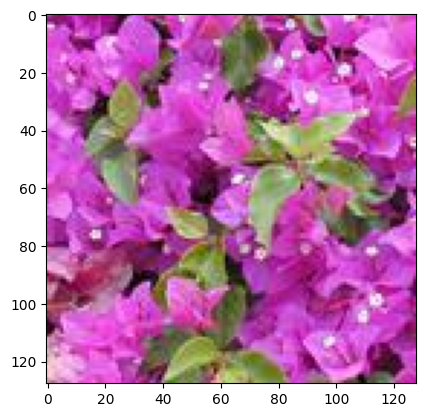

Sample shape : (128, 128, 3)


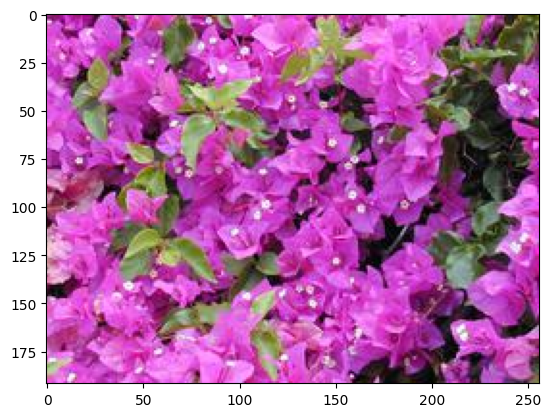

Sample shape : (192, 256, 3)


In [41]:
subimg_sample = list(subimgs_path.iterdir())[0]

test_imgs = [subimg_sample, imgs[0]]

for img in test_imgs:
    sample = Image.open(img)
    sample_arr = np.asarray(sample)
    plt.imshow(sample_arr), plt.show()
    print("Sample shape :", sample_arr.shape)

Precision software engineering! Let's use our function to create another that creates five such images.

In [55]:
def create_sub_imgs(img_path, dst_path, subimg_size):
    locs = ['top_left', 'bottom_left', 'top_right', 'bottom_right', 'middle']
    for loc in locs:
        create_sub_img(img_path, dst_path, subimg_size, loc)

In [59]:
create_sub_imgs(img_paths[0], subimgs_path, subimg_size)

In [68]:
subimg_samples = list(subimgs_path.iterdir())
subimg_samples.append(imgs[0])
subimg_samples

[WindowsPath('sub_images/bougainvillea_00003_bottom_left.jpg'),
 WindowsPath('sub_images/bougainvillea_00003_bottom_right.jpg'),
 WindowsPath('sub_images/bougainvillea_00003_middle.jpg'),
 WindowsPath('sub_images/bougainvillea_00003_top_left.jpg'),
 WindowsPath('sub_images/bougainvillea_00003_top_right.jpg'),
 WindowsPath('resized_flower_images/bougainvillea_00003.jpg')]

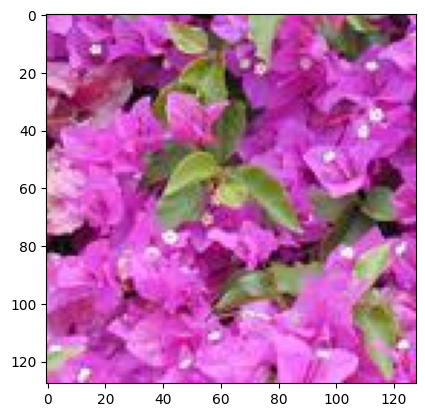

sub_images\bougainvillea_00003_bottom_left.jpg
Sample shape : (128, 128, 3)


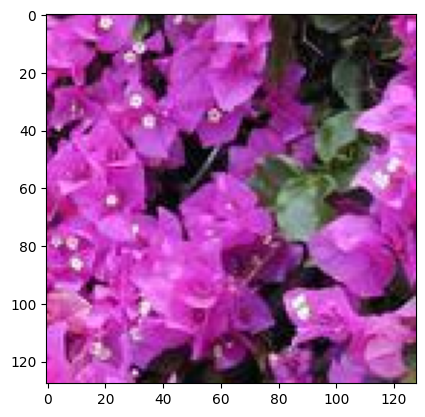

sub_images\bougainvillea_00003_bottom_right.jpg
Sample shape : (128, 128, 3)


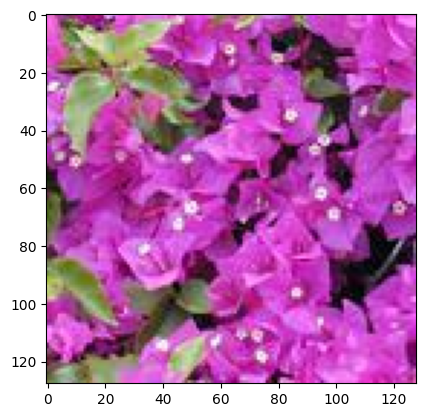

sub_images\bougainvillea_00003_middle.jpg
Sample shape : (128, 128, 3)


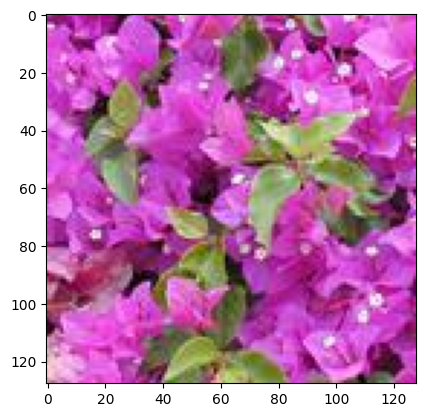

sub_images\bougainvillea_00003_top_left.jpg
Sample shape : (128, 128, 3)


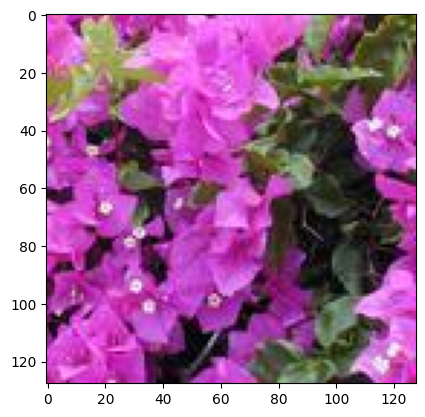

sub_images\bougainvillea_00003_top_right.jpg
Sample shape : (128, 128, 3)


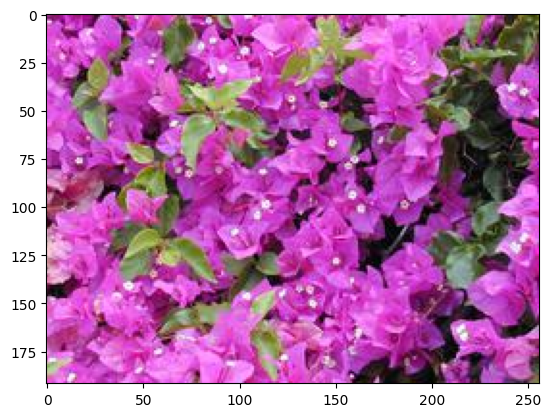

resized_flower_images\bougainvillea_00003.jpg
Sample shape : (192, 256, 3)


In [69]:
for img in subimg_samples:
    sample = Image.open(img)
    sample_arr = np.asarray(sample)
    plt.imshow(sample_arr), plt.show()
    print(str(img))
    print("Sample shape :", sample_arr.shape)

Looks good! Let's create a function that creates subimages for a whole folder, then remove the contents of our current subimg folder and run the function. We can then assert ```len(data_path) * 5 == len(subimg_folder)``` to see if it has worked correctly.

In [ ]:
# get labels
y = [label.split('_')[0] for label in os.listdir(data_path)]
y[0:5]

Easy!

In [ ]:
plt.imshow(random_image, cmap='gray')
plt.colorbar();
# np.stack(X_image_array) 

In [ ]:
plt.imshow(np.real(imgs[0]))
plt.show()